# EP-12 트랜스포머로 만드는 대화형 챗봇

## 프로젝트 진행 순서
    1. 데이터 수집하기
    2. 데이터 전처리하기
    3. 트랜스포머 모델 구현하기
    4. 모델 평가 및 개선
    5. 회고 및 정리

### 데이터 수집하기
  - 이번에 만들 챗봇에 사용되는 데이터는 한국어로 이루어져 있고 송영숙님이 공개한 챗봇 데이터를 사용해서 진행한다.

In [1]:
# 사용할 라이브러리 import

import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print("finish")

finish


In [2]:
# 사용할 데이터 불러오기

dataset_file_path = os.getenv('HOME') + '/aiffel/transformer_chatbot/data/ChatbotData.csv'
data = pd.read_csv(dataset_file_path)
data.head(10)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.,0
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0


In [3]:
print('챗봇 샘플의 개수 :', len(data))

챗봇 샘플의 개수 : 11823


### 데이터 전처리하기

In [4]:
# 데이터 전처리 함수 정의하기

def preprocess_sentence(sentence):
  # 영어 소문자 변환 및 양쪽 공백 제거  
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 공백 추가
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (한글, a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자 공백으로 대체
  sentence = re.sub(r"[^가-힣a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
    
  return sentence
print("finish")

finish


In [5]:
def load_conversations():
    with open(dataset_file_path, errors='ignore') as file:
        lines = file.readlines()
        
    inputs, outputs = [], []
    with open(dataset_file_path) as file:
        lines = csv.reader(file)
        next(lines)
        # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
        for line in lines:
            inputs.append(preprocess_sentence(line[0]))
            outputs.append(preprocess_sentence(line[1]))
    return inputs, outputs
print("finish")

finish


In [7]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장

questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))
print()
print('전처리 후의 31번째 질문 샘플: {}'.format(questions[31]))
print('전처리 후의 32번째 답변 샘플: {}'.format(answers[32]))

전체 샘플 수 : 11823
전체 샘플 수 : 11823

전처리 후의 31번째 질문 샘플: 가족들이랑 서먹해졌어
전처리 후의 32번째 답변 샘플: 온 가족이 모두 마음에 드는 곳으로 가보세요 .


In [8]:
# 단어장(Vocabulary)만들기

import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("finish")

finish


In [10]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.

START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("finish")

finish


In [11]:
# 시작 토큰과 종료 토큰에 부여된 정수를 출력해본다.

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8133]
END_TOKEN의 번호 : [8134]


In [13]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.

VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8135


In [14]:
# 정수로 인코딩
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환

print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5742, 610, 2483, 4148]
정수 인코딩 후의 21번째 답변 샘플: [2353, 7484, 7, 6249, 97, 1]


In [15]:
# 문장 길이 평균 확인

questions_len = [len(s.split()) for s in questions]
answers_len = [len(s.split()) for s in answers]
print(f'questions 최대 길이 : {np.max(questions_len)}')
print(f'questions 평균 길이 : {np.mean(questions_len)}')
print(f'answers 최대 길이 : {np.max(answers_len)}')
print(f'answers 평균 길이 : {np.mean(answers_len)}')

questions 최대 길이 : 16
questions 평균 길이 : 3.9391017508246637
answers 최대 길이 : 24
answers 평균 길이 : 4.716146494121627


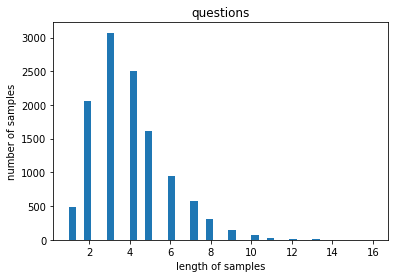

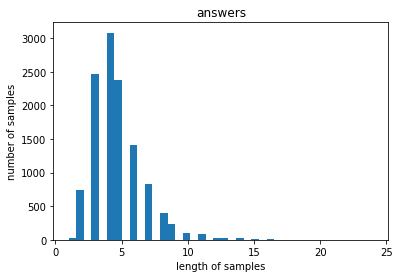

In [16]:
plt.title('questions')
plt.hist(questions_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('answers')
plt.hist(answers_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
# 문장의 최대 길이가 10을 넘는 데이터가 거의 없기 때문에 최대 허용 길이를 10으로 설정

MAX_LENGTH = 10
print(MAX_LENGTH)

10


In [18]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("finish")

finish


In [19]:
# 정수 인코딩 과정 및 최대 길이 초과 샘플 제거 후 단어장의 크기와 샘플의 개수 확인

questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8135
필터링 후의 질문 샘플 개수: 9128
필터링 후의 답변 샘플 개수: 9128


In [20]:
# 교사 강요(Teacher Forcing) 사용하기

BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("finish")

finish


### 트랜스포머 모델 구현하기

In [21]:
# 1. 포지셔널 인코딩 레이어

class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("finish")

finish


In [22]:
# 2. 스케일드 닷 프로덕트 어텐션 함수

def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("finish")

finish


In [23]:
# 3. 멀티 헤드 어텐션

class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("finish")

finish


In [24]:
# 4. 패딩 마스킹

def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("finish")

finish


In [25]:
# 5. 룩 어헤드 마스킹

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("finish")

finish


In [26]:
# 6. 인코더 레이어 함수 구현
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.

def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("finish")

finish


In [27]:
# 7. 인코더 함수 정의

def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("finish")

finish


In [28]:
# 8. 디코더 레이어 함수 구현
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.

def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("finish")

finish


In [29]:
# 9. 디코더 함수 정의

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("finish")

finish


In [30]:
# 10. 트랜스포머 모델 정의

def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("finish")

finish


In [31]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3136768     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [32]:
# 손실 함수 정의

def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("어렵다")

어렵다


In [33]:
# 커스텀 된 학습률

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("뭔말인지 모르겠어")

뭔말인지 모르겠어


In [34]:
# 모델 컴파일

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("드디어 끝인건가")

드디어 끝인건가


In [35]:
# 훈련하기

EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
143/143 [==============================] - 10s 26ms/step - loss: 5.5811 - accuracy: 0.1079
Epoch 2/20
143/143 [==============================] - 4s 26ms/step - loss: 4.6653 - accuracy: 0.2122
Epoch 3/20
143/143 [==============================] - 4s 26ms/step - loss: 3.8909 - accuracy: 0.2153
Epoch 4/20
143/143 [==============================] - 4s 26ms/step - loss: 3.5028 - accuracy: 0.2198
Epoch 5/20
143/143 [==============================] - 4s 26ms/step - loss: 3.2858 - accuracy: 0.2305
Epoch 6/20
143/143 [==============================] - 4s 26ms/step - loss: 3.0945 - accuracy: 0.2417
Epoch 7/20
143/143 [==============================] - 4s 26ms/step - loss: 2.8970 - accuracy: 0.2584
Epoch 8/20
143/143 [==============================] - 4s 25ms/step - loss: 2.6834 - accuracy: 0.2799
Epoch 9/20
143/143 [==============================] - 4s 26ms/step - loss: 2.4435 - accuracy: 0.3097
Epoch 10/20
143/143 [==============================] - 4s 26ms/step - loss: 2.1880 - accur

### 모델 평가 및 개선

In [36]:
# 평가를 위한 decoder_inference() 함수 생성

def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("휴")

휴


In [37]:
# 챗봇의 대답을 얻는 sentence_generation() 함수 생성

def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("끄읏")

끄읏


In [38]:
sentence_generation('밥 먹었니?')

입력 : 밥 먹었니?
출력 : 배고프지 않아요 .


'배고프지 않아요 .'

In [39]:
sentence_generation('오늘 뭐해?')

입력 : 오늘 뭐해?
출력 : 냉장고 파먹기 해보세요 .


'냉장고 파먹기 해보세요 .'

In [42]:
sentence_generation('아프다')

입력 : 아프다
출력 : 조금만 아팠으면 좋겠어요 .


'조금만 아팠으면 좋겠어요 .'

In [45]:
sentence_generation('기분이 좋다')

입력 : 기분이 좋다
출력 : 제가 있잖아요 .


'제가 있잖아요 .'

In [46]:
# EPOCHS 늘려서 재훈련하기

EPOCHS = 40
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/40
143/143 [==============================] - 4s 27ms/step - loss: 0.1395 - accuracy: 0.6401
Epoch 2/40
143/143 [==============================] - 4s 25ms/step - loss: 0.1158 - accuracy: 0.6428
Epoch 3/40
143/143 [==============================] - 4s 26ms/step - loss: 0.1044 - accuracy: 0.6441
Epoch 4/40
143/143 [==============================] - 4s 26ms/step - loss: 0.0998 - accuracy: 0.6444
Epoch 5/40
143/143 [==============================] - 4s 26ms/step - loss: 0.0912 - accuracy: 0.6456
Epoch 6/40
143/143 [==============================] - 4s 26ms/step - loss: 0.0867 - accuracy: 0.6462
Epoch 7/40
143/143 [==============================] - 4s 26ms/step - loss: 0.0859 - accuracy: 0.6463
Epoch 8/40
143/143 [==============================] - 4s 26ms/step - loss: 0.0869 - accuracy: 0.6460
Epoch 9/40
143/143 [==============================] - 4s 26ms/step - loss: 0.0847 - accuracy: 0.6462
Epoch 10/40
143/143 [==============================] - 4s 26ms/step - loss: 0.0746 - accura

In [47]:
sentence_generation('밥 먹었니?')

입력 : 밥 먹었니?
출력 : 배고프지 않아요 .


'배고프지 않아요 .'

In [49]:
sentence_generation('아프다')

입력 : 아프다
출력 : 조금만 아팠으면 좋겠어요 .


'조금만 아팠으면 좋겠어요 .'

In [50]:
sentence_generation('기분이 좋다')

입력 : 기분이 좋다
출력 : 경쾌한 음악 들어보세요 .


'경쾌한 음악 들어보세요 .'

In [51]:
sentence_generation('날씨 어때?')

입력 : 날씨 어때?
출력 : 날씨 어플에 물어보세요 .


'날씨 어플에 물어보세요 .'

In [52]:
sentence_generation('춥다')

입력 : 춥다
출력 : 따뜻하게 입으세요 .


'따뜻하게 입으세요 .'

In [53]:
sentence_generation('너무 화가나')

입력 : 너무 화가나
출력 : 자신을 탓하지 마세요 .


'자신을 탓하지 마세요 .'

## 회고 및 정리

### 어려웠던 점
1. 오늘 노드를 진행하면서 처음 데이터 전처리부터 큰 어려움을 겪었다. 노드에서 제공하는 가이드는 영어 데이터 전처리에 관한 코드였고 내가 해야 하는 것은 한글 데이터를 가지고 전처리를 진행해야 했기 때문에 추가적인 전처리 과정이 더 필요하였다. 구글에 검색을 하면 한글 데이터 전처리에 관한 내용과 코드들이 많이 나온다. 하지만 아이펠 노드 가이드에 맞춰서 그 코드들을 추가하는 것이 진짜 어려웠다. 그냥 단순하게 코드만 복사 / 붙여넣기 하면 또 어디선가 에러가 나기 때문에 흐름에 맞게 코드를 짠다는 것이 얼마나 어려운 일인지 다시 느낄 수 있었다.


2. 노드에 대한 정보를 얻고자 깃허브랑 구글 등을 둘러보다가 같은 실습인데 다른 방법으로 전처리를 진행한 사람의 글을 보았다. 생각해보면 노드에서 제공하는 전처리 가이드가 어려우면 다른 방식을 통한 전처리를 진행해도 모델이 작동하는데는 큰 문제가 없을텐데 그 부분까지 생각하지 못했다. 아직 NLP 관련된 지식도 적고 직접 실습을 해본 경험도 적기 때문에 경험이 많이 부족함을 느꼈다.


3. 오늘 노드의 주제는 트랜스포머를 통해서 대화형 챗봇을 만드는 것이었다. 지금까지 노드를 진행하면서 NLP 모델들도 몇가지 공부했지만 오늘이 가장 어려웠던 것 같다. 특히 모델을 구성하는 구성요소도 많았고 각각의 구성요소들의 작동원리 역시 이해하지 못했다. 물론 추후에 더 많은 데이터와 좋은 결과를 얻기 위해서는 깊은 모델을 만드는 것이 중요하기 때문에 많은 공부와 연습이 필요하다는 것을 알지만 역시 NLP 분야가 CV 분야보다 더 어려운 것 같다.

### 정리
이번 노드를 진행하면서 진짜 하나도 이해가 안되서 구글이랑 깃허브에서 이것저것 많이 찾아본 것 같다. 찾아보면서 aiffel을 먼저 수료한 사람의 자료도 읽어보고 특히 우리랑 똑같은 데이터셋을 가지고 설명과 실습을 진행한 홈페이지가 있어서 그것도 읽어봤는데 나는 진짜 어렵고 복잡하게 생각한 것을 거기서는 엄청 간단하고 간략하게 정리해서 모델을 만들고 실습한 것을 볼 수 있었다. 물론 난 완전 초보의 입장에서 배우기 때문에 그런 수준의 코딩은 아직 어렵다고 생각했지만 왜 나는 엄청 복잡하고 어렵다고 생각한걸 그 글을 쓴 작성자는 쉽고 간단하게 생각해서 간략하게 코딩을 할 수 있었을까? 라는 질문이 들었다. 내가 작성한 자료들과 깃허브 및 여러 구글링한 자료들을 비교해서 보면서 생각의 전환과 지금 온라인 상에 존재하는 무궁 무진한 데이터 및 정보를 잘 이용하는게 정말 큰 능력이라는 생각이 들었다.

### 참고한 자료

1. 트랜스포머를 이용한 한국어 챗봇 : https://wikidocs.net/31379 / https://wikidocs.net/89786
2. 아이펠 수료자 깃허브 : https://github.com/Kim-Gwang-Min/Exploration/blob/master/EX15%20Making%20a%20chatbot%20with%20transformer.ipynb
3. konlpy로 데이터 전처리 진행 : https://github.com/jiyeoon/aiffel/blob/master/Week12/Exploration21(2).ipynb